# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

c:\Users\thama\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.16.1', '4.38.1', '2.1.1+cpu')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


## 1. Loading our MNLI part of the GLUE dataset

In [4]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

Using the latest cached version of the dataset since glue couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'mnli' at C:\Users\thama\.cache\huggingface\datasets\glue\mnli\0.0.0\bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c (last modified on Wed Mar 13 00:15:55 2024).


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [5]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [6]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

## 2. Model & Tokenization

In [7]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [9]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [10]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [11]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [12]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [13]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [14]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

## 4. Preparing the dataloader

In [15]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [16]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(5000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(100))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(100))

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [18]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 81]), torch.Size([32, 81]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [19]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [20]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [21]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [22]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

## Task1

In [23]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights_topk(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_topk(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers

        #task1.1 top-k layer
        # for i in range(len(student_encoding_layers)):
        #     student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
        for i in range(6):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [24]:
def distill_bert_weights_bottomk(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_bottomk(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers

        #task1.2 bottom-k layer
        for i in range(0,6,1):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i+6].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [25]:
def distill_bert_weights_odd(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_odd(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers

        #task1.3 odd layer
        # for i in range(len(student_encoding_layers)):
        #     student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[(2*i)+1].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [26]:
def distill_bert_weights_even(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_even(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers

        # even layer
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [27]:
topk_layer = distill_bert_weights_topk(teacher=teacher_model, student=model)
bottomk_layer = distill_bert_weights_bottomk(teacher=teacher_model, student=model)
odd_layer = distill_bert_weights_odd(teacher=teacher_model, student=model)
even_layer = distill_bert_weights_even(teacher=teacher_model, student=model)

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model))

Teacher parameters : 109484547
Student parameters : 66957315


In [29]:
print('top k layer: ',count_parameters(topk_layer)/count_parameters(teacher_model) * 100)
print('bottom k layer: ',count_parameters(bottomk_layer)/count_parameters(teacher_model) * 100)
print('odd layer: ',count_parameters(odd_layer)/count_parameters(teacher_model) * 100)
print('even layer: ',count_parameters(even_layer)/count_parameters(teacher_model) * 100)

top k layer:  61.15686353435797
bottom k layer:  61.15686353435797
odd layer:  61.15686353435797
even layer:  61.15686353435797


### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [31]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [32]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [33]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)
optimizer_topk = optim.Adam(params=topk_layer.parameters(), lr=lr)
optimizer_bottomk = optim.Adam(params=bottomk_layer.parameters(), lr=lr)
optimizer_odd = optim.Adam(params=odd_layer.parameters(), lr=lr)
optimizer_even = optim.Adam(params=even_layer.parameters(), lr=lr)

In [34]:
# model = model.to(device)
topk_layer = topk_layer.to(device)
bottomk_layer = bottomk_layer.to(device) 
odd_layer = odd_layer.to(device)
even_layer = even_layer.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [35]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

#learning rate scheduler for teacher model
lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)
#learning rate scheduler for top-k layer model
lr_scheduler_topk = get_scheduler(
    name="linear", 
    optimizer=optimizer_topk, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)
#learning rate scheduler for bottom-k layer model
lr_scheduler_bottomk = get_scheduler(
    name="linear", 
    optimizer=optimizer_bottomk, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)
#learning rate scheduler for odd layer model
lr_scheduler_odd = get_scheduler(
    name="linear", 
    optimizer=optimizer_odd, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)
#learning rate scheduler for even layer model
lr_scheduler_even = get_scheduler(
    name="linear", 
    optimizer=optimizer_even, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [36]:
# !pip3 install evaluate

In [37]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

Using the latest cached version of the module from C:\Users\thama\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--glue\05234ba7acc44554edcca0978db5fa3bc600eeee66229abe79ff9887eacaf3ed (last modified on Tue Mar 12 22:39:02 2024) since it couldn't be found locally at evaluate-metric--glue, or remotely on the Hugging Face Hub.


## 9. Train

## Task2

### Top K Layer

In [38]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics_topk = 0

# Lists to store losses for each epoch
train_losses_topk = []
train_losses_cls_topk = []
train_losses_div_topk = []
train_losses_cos_topk = []
eval_losses_topk = []
print('Top K Layer')
for epoch in range(num_epochs):
    topk_layer.train()
    teacher_model.eval()
    train_loss_topk = 0
    train_loss_cls_topk = 0
    train_loss_div_topk = 0
    train_loss_cos_topk = 0
     
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = topk_layer(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls_topk += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div_topk += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos_topk += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss_topk += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_topk.step()
        lr_scheduler_topk.step()
        optimizer_topk.zero_grad()
        progress_bar.update(1)
        
    train_losses_topk.append(train_loss_topk / len(train_dataloader))
    train_losses_cls_topk.append(train_loss_cls_topk / len(train_dataloader))
    train_losses_div_topk.append(train_loss_div_topk / len(train_dataloader))
    train_losses_cos_topk.append(train_loss_cos_topk / len(train_dataloader))

    
    print(f'Epoch at {epoch+1}: Train loss {train_loss_topk/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls_topk/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div_topk/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos_topk/len(train_dataloader):.4f}')
    
    topk_layer.eval()
    eval_loss_topk = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = topk_layer(**batch)
            
        loss_cls_topk = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss_topk += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics_topk += eval_metric['accuracy'] 
    eval_losses_topk.append(eval_loss_topk / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    print(f'Epoch at {epoch+1}: Val loss {eval_loss_topk/len(eval_dataloader):.4f}:')
    
    
print('Avg Metric', eval_metrics_topk/num_epochs)

  0%|          | 0/785 [00:00<?, ?it/s]

Top K Layer


 20%|██        | 157/785 [18:34<1:00:59,  5.83s/it]

Epoch at 1: Train loss 0.3724:
  - Loss_cls: 1.0399
  - Loss_div: 0.0260
  - Loss_cos: 0.0513
Epoch at 1: Test Acc 0.5900
Epoch at 1: Val loss 1.0244:


 40%|████      | 314/785 [44:16<1:06:57,  8.53s/it]

Epoch at 2: Train loss 0.3270:
  - Loss_cls: 0.8538
  - Loss_div: 0.0786
  - Loss_cos: 0.0484
Epoch at 2: Test Acc 0.6400
Epoch at 2: Val loss 1.0075:


 60%|██████    | 471/785 [1:10:29<38:49,  7.42s/it]  

Epoch at 3: Train loss 0.2865:
  - Loss_cls: 0.6717
  - Loss_div: 0.1364
  - Loss_cos: 0.0514
Epoch at 3: Test Acc 0.5800
Epoch at 3: Val loss 0.6214:


 80%|████████  | 628/785 [1:36:15<22:54,  8.75s/it]

Epoch at 4: Train loss 0.2621:
  - Loss_cls: 0.5595
  - Loss_div: 0.1746
  - Loss_cos: 0.0521
Epoch at 4: Test Acc 0.6500
Epoch at 4: Val loss 0.6428:


100%|██████████| 785/785 [1:59:40<00:00,  5.30s/it]

Epoch at 5: Train loss 0.2509:
  - Loss_cls: 0.5119
  - Loss_div: 0.1893
  - Loss_cos: 0.0515
Epoch at 5: Test Acc 0.6400
Epoch at 5: Val loss 0.5386:
Avg Metric 0.62


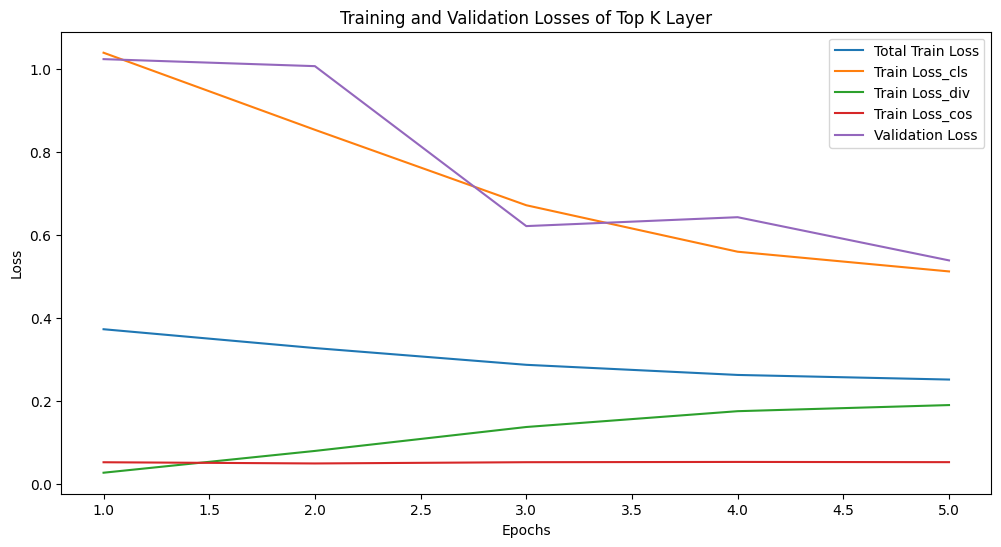

In [39]:
import matplotlib.pyplot as plt
# Plotting
epochs_list_topk = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list_topk, train_losses_topk, label='Total Train Loss')
plt.plot(epochs_list_topk, train_losses_cls_topk, label='Train Loss_cls')
plt.plot(epochs_list_topk, train_losses_div_topk, label='Train Loss_div')
plt.plot(epochs_list_topk, train_losses_cos_topk, label='Train Loss_cos')
plt.plot(epochs_list_topk, eval_losses_topk, label='Validation Loss')


plt.title('Training and Validation Losses of Top K Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Bottom K Layer

In [40]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics_bottomk = 0

# Lists to store losses for each epoch
train_losses_bottomk = []
train_losses_cls_bottomk = []
train_losses_div_bottomk = []
train_losses_cos_bottomk = []
eval_losses_bottomk = []
print('Bottom K Layer')
for epoch in range(num_epochs):
    bottomk_layer.train()
    teacher_model.eval()
    train_loss_bottomk = 0
    train_loss_cls_bottomk = 0
    train_loss_div_bottomk = 0
    train_loss_cos_bottomk = 0
     
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = bottomk_layer(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls_bottomk += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div_bottomk += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos_bottomk += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss_bottomk += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_bottomk.step()
        lr_scheduler_bottomk.step()
        optimizer_bottomk.zero_grad()
        progress_bar.update(1)
        
    train_losses_bottomk.append(train_loss_bottomk / len(train_dataloader))
    train_losses_cls_bottomk.append(train_loss_cls_bottomk / len(train_dataloader))
    train_losses_div_bottomk.append(train_loss_div_bottomk / len(train_dataloader))
    train_losses_cos_bottomk.append(train_loss_cos_bottomk / len(train_dataloader))

    
    print(f'Epoch at {epoch+1}: Train loss {train_loss_bottomk/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls_bottomk/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div_bottomk/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos_bottomk/len(train_dataloader):.4f}')
    
    bottomk_layer.eval()
    eval_loss_bottomk = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = bottomk_layer(**batch)
            
        loss_cls_bottomk = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss_bottomk += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics_bottomk += eval_metric['accuracy'] 
    eval_losses_bottomk.append(eval_loss_bottomk / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    print(f'Epoch at {epoch+1}: Val loss {eval_loss_bottomk/len(eval_dataloader):.4f}:')
    
    
print('Avg Metric', eval_metrics_bottomk/num_epochs)

100%|██████████| 785/785 [1:59:45<00:00,  9.15s/it]


Bottom K Layer


Epoch at 1: Train loss 0.2557:
  - Loss_cls: 0.5268
  - Loss_div: 0.1911
  - Loss_cos: 0.0492
Epoch at 1: Test Acc 0.5900
Epoch at 1: Val loss 0.6325:


Epoch at 2: Train loss 0.2455:
  - Loss_cls: 0.4824
  - Loss_div: 0.2067
  - Loss_cos: 0.0476
Epoch at 2: Test Acc 0.6800
Epoch at 2: Val loss 0.7765:


Epoch at 3: Train loss 0.2398:
  - Loss_cls: 0.4590
  - Loss_div: 0.2142
  - Loss_cos: 0.0463
Epoch at 3: Test Acc 0.6300
Epoch at 3: Val loss 0.5438:


Epoch at 4: Train loss 0.2351:
  - Loss_cls: 0.4378
  - Loss_div: 0.2218
  - Loss_cos: 0.0457
Epoch at 4: Test Acc 0.6400
Epoch at 4: Val loss 0.3993:


Epoch at 5: Train loss 0.2333:
  - Loss_cls: 0.4319
  - Loss_div: 0.2230
  - Loss_cos: 0.0451
Epoch at 5: Test Acc 0.6400
Epoch at 5: Val loss 0.4389:
Avg Metric 0.636


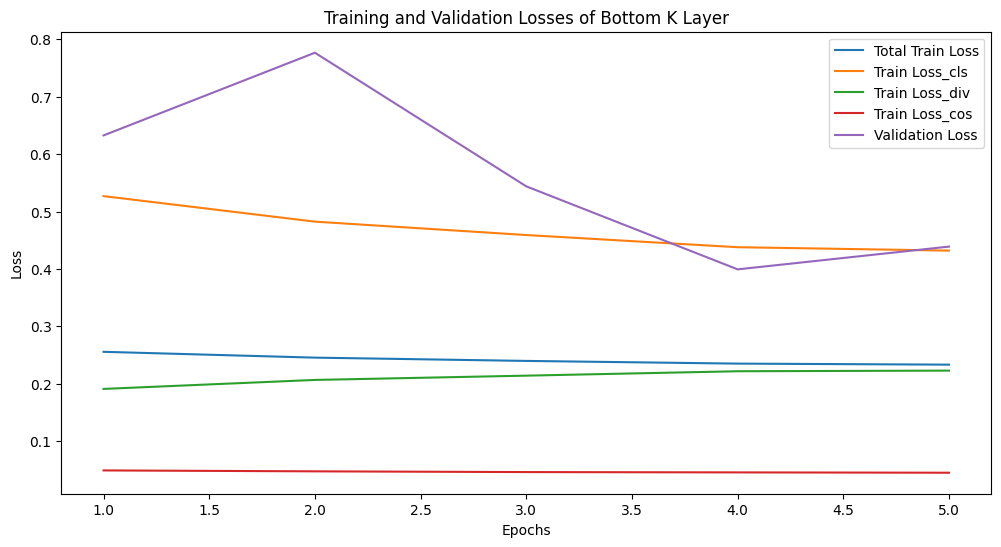

In [41]:
import matplotlib.pyplot as plt
# Plotting
epochs_list_bottomk = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list_bottomk, train_losses_bottomk, label='Total Train Loss')
plt.plot(epochs_list_bottomk, train_losses_cls_bottomk, label='Train Loss_cls')
plt.plot(epochs_list_bottomk, train_losses_div_bottomk, label='Train Loss_div')
plt.plot(epochs_list_bottomk, train_losses_cos_bottomk, label='Train Loss_cos')
plt.plot(epochs_list_bottomk, eval_losses_bottomk, label='Validation Loss')


plt.title('Training and Validation Losses of Bottom K Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Odd Layer

In [42]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics_odd = 0

# Lists to store losses for each epoch
train_losses_odd = []
train_losses_cls_odd = []
train_losses_div_odd = []
train_losses_cos_odd = []
eval_losses_odd = []
print('Odd Layer')
for epoch in range(num_epochs):
    odd_layer.train()
    teacher_model.eval()
    train_loss_odd = 0
    train_loss_cls_odd = 0
    train_loss_div_odd = 0
    train_loss_cos_odd = 0
     
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = odd_layer(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls_odd += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div_odd += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos_odd += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss_odd += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_odd.step()
        lr_scheduler_odd.step()
        optimizer_odd.zero_grad()
        progress_bar.update(1)
        
    train_losses_odd.append(train_loss_odd / len(train_dataloader))
    train_losses_cls_odd.append(train_loss_cls_odd / len(train_dataloader))
    train_losses_div_odd.append(train_loss_div_odd / len(train_dataloader))
    train_losses_cos_odd.append(train_loss_cos_odd / len(train_dataloader))

    
    print(f'Epoch at {epoch+1}: Train loss {train_loss_odd/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls_odd/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div_odd/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos_odd/len(train_dataloader):.4f}')
    
    odd_layer.eval()
    eval_loss_odd = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = odd_layer(**batch)
            
        loss_cls_odd = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss_odd += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics_odd += eval_metric['accuracy'] 
    eval_losses_odd.append(eval_loss_odd / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    print(f'Epoch at {epoch+1}: Val loss {eval_loss_odd/len(eval_dataloader):.4f}:')
    
    
print('Avg Metric', eval_metrics_odd/num_epochs)

100%|██████████| 785/785 [1:56:21<00:00,  8.89s/it]


Odd Layer


 20%|██        | 157/785 [24:23<1:18:40,  7.52s/it]

Epoch at 1: Train loss 0.2382:
  - Loss_cls: 0.4508
  - Loss_div: 0.2192
  - Loss_cos: 0.0446
Epoch at 1: Test Acc 0.6600
Epoch at 1: Val loss 0.4092:


 40%|████      | 314/785 [49:40<47:54,  6.10s/it]  

Epoch at 2: Train loss 0.2359:
  - Loss_cls: 0.4417
  - Loss_div: 0.2222
  - Loss_cos: 0.0438
Epoch at 2: Test Acc 0.6500
Epoch at 2: Val loss 0.4036:


 60%|██████    | 471/785 [1:13:17<33:38,  6.43s/it]  

Epoch at 3: Train loss 0.2326:
  - Loss_cls: 0.4286
  - Loss_div: 0.2258
  - Loss_cos: 0.0435
Epoch at 3: Test Acc 0.6200
Epoch at 3: Val loss 0.4141:


 80%|████████  | 628/785 [1:37:40<19:29,  7.45s/it]

Epoch at 4: Train loss 0.2313:
  - Loss_cls: 0.4225
  - Loss_div: 0.2285
  - Loss_cos: 0.0431
Epoch at 4: Test Acc 0.6300
Epoch at 4: Val loss 0.4071:


100%|██████████| 785/785 [2:03:07<00:00,  7.40s/it]

Epoch at 5: Train loss 0.2313:
  - Loss_cls: 0.4217
  - Loss_div: 0.2284
  - Loss_cos: 0.0437
Epoch at 5: Test Acc 0.6100
Epoch at 5: Val loss 0.4530:
Avg Metric 0.634


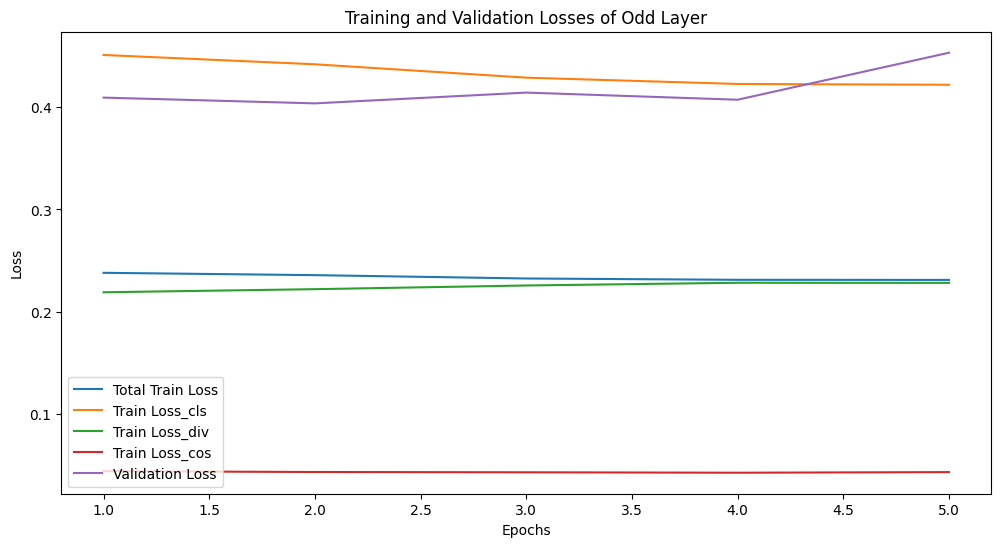

In [43]:
import matplotlib.pyplot as plt
# Plotting
epochs_list_odd = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list_odd, train_losses_odd, label='Total Train Loss')
plt.plot(epochs_list_odd, train_losses_cls_odd, label='Train Loss_cls')
plt.plot(epochs_list_odd, train_losses_div_odd, label='Train Loss_div')
plt.plot(epochs_list_odd, train_losses_cos_odd, label='Train Loss_cos')
plt.plot(epochs_list_odd, eval_losses_odd, label='Validation Loss')


plt.title('Training and Validation Losses of Odd Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Even Layer

In [44]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics_even = 0

# Lists to store losses for each epoch
train_losses_even = []
train_losses_cls_even = []
train_losses_div_even = []
train_losses_cos_even = []
eval_losses_even = []
print('Even Layer')
for epoch in range(num_epochs):
    even_layer.train()
    teacher_model.eval()
    train_loss_even = 0
    train_loss_cls_even = 0
    train_loss_div_even = 0
    train_loss_cos_even = 0
     
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = even_layer(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls_even += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div_even += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos_even += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss_even += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_even.step()
        lr_scheduler_even.step()
        optimizer_even.zero_grad()
        progress_bar.update(1)
        
    train_losses_even.append(train_loss_even / len(train_dataloader))
    train_losses_cls_even.append(train_loss_cls_even / len(train_dataloader))
    train_losses_div_even.append(train_loss_div_even / len(train_dataloader))
    train_losses_cos_even.append(train_loss_cos_even / len(train_dataloader))

    
    print(f'Epoch at {epoch+1}: Train loss {train_loss_even/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls_even/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div_even/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos_even/len(train_dataloader):.4f}')
    
    even_layer.eval()
    eval_loss_even = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = even_layer(**batch)
            
        loss_cls_even = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss_even += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics_even += eval_metric['accuracy'] 
    eval_losses_even.append(eval_loss_even / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    print(f'Epoch at {epoch+1}: Val loss {eval_loss_even/len(eval_dataloader):.4f}:')
    
    
print('Avg Metric', eval_metrics_even/num_epochs)

100%|██████████| 785/785 [2:03:14<00:00,  9.42s/it]


Even Layer


Epoch at 1: Train loss 0.2343:
  - Loss_cls: 0.4336
  - Loss_div: 0.2259
  - Loss_cos: 0.0436
Epoch at 1: Test Acc 0.6400
Epoch at 1: Val loss 0.4621:


Epoch at 2: Train loss 0.2344:
  - Loss_cls: 0.4366
  - Loss_div: 0.2247
  - Loss_cos: 0.0420
Epoch at 2: Test Acc 0.6200
Epoch at 2: Val loss 0.4062:


Epoch at 3: Train loss 0.2318:
  - Loss_cls: 0.4265
  - Loss_div: 0.2270
  - Loss_cos: 0.0419
Epoch at 3: Test Acc 0.6500
Epoch at 3: Val loss 0.4011:


Epoch at 4: Train loss 0.2311:
  - Loss_cls: 0.4227
  - Loss_div: 0.2289
  - Loss_cos: 0.0418
Epoch at 4: Test Acc 0.6100
Epoch at 4: Val loss 0.4067:


Epoch at 5: Train loss 0.2298:
  - Loss_cls: 0.4182
  - Loss_div: 0.2294
  - Loss_cos: 0.0417
Epoch at 5: Test Acc 0.6300
Epoch at 5: Val loss 0.4092:
Avg Metric 0.63


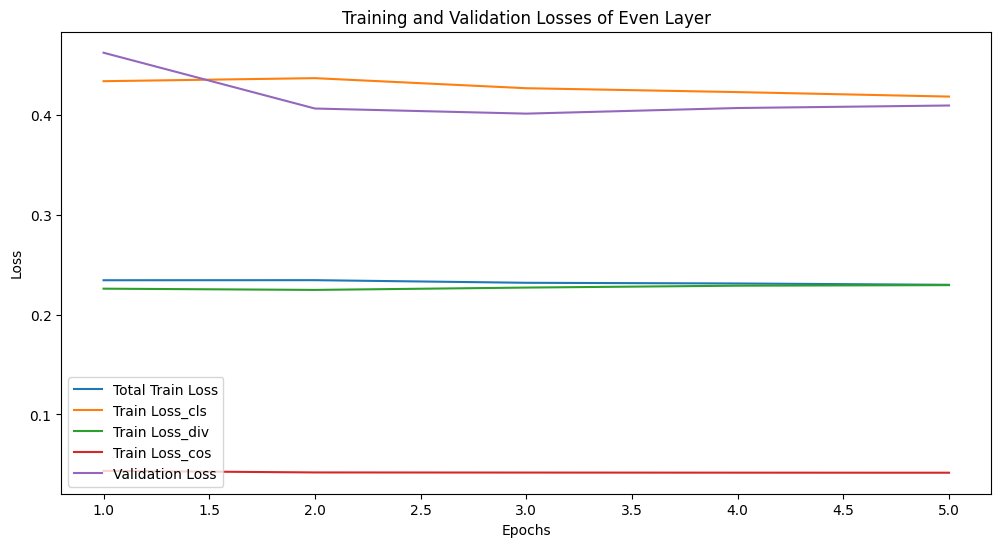

In [45]:
import matplotlib.pyplot as plt
# Plotting
epochs_list_even = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list_even, train_losses_even, label='Total Train Loss')
plt.plot(epochs_list_even, train_losses_cls_even, label='Train Loss_cls')
plt.plot(epochs_list_even, train_losses_div_even, label='Train Loss_div')
plt.plot(epochs_list_even, train_losses_cos_even, label='Train Loss_cos')
plt.plot(epochs_list_even, eval_losses_even, label='Validation Loss')


plt.title('Training and Validation Losses of Even Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Appendix (Teacher Model)

In [47]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

 24%|██▍       | 188/785 [2:51:35<9:04:53, 54.76s/it]


Epoch at 1: Train loss 0.4471
Epoch at 1: Test Acc 0.7200


Epoch at 2: Train loss 0.2092
Epoch at 2: Test Acc 0.7300


Epoch at 3: Train loss 0.1225
Epoch at 3: Test Acc 0.7300


Epoch at 4: Train loss 0.0767
Epoch at 4: Test Acc 0.7500


Epoch at 5: Train loss 0.0639
Epoch at 5: Test Acc 0.7200
Avg Metric 0.7299999999999999


## Discussion and Analysis

| Student Layer | Training Loss | Validation Loss | Validation Accuracy |
|---------------|---------------|-----------------|---------------------|
| Top-K Layer   |    0.2509     |      0.5386     |       0.6400        |
| Bottom-K Layer|    0.2333     |      0.4389     |       0.6400        |
| Odd Layer     |    0.2313     |      0.4530     |       0.6100        |
| Even Layer    |    0.2298     |      0.4092     |       0.6300        |

The results indicate a noticeable impact of the initial layer selection on the performance of the student model. Notably, the Top-K layer initialization exhibits slightly higher training loss compared to other initializations, which may suggest that initially focusing on high-level representations might lead to more complex decision boundaries, resulting in higher training loss. However, this initialization also shows relatively higher validation accuracy, indicating that despite the increased complexity, the model can generalize well on unseen data. Conversely, the Bottom-K layer initialization demonstrates lower training and validation losses, implying that starting from lower-level representations might facilitate smoother optimization and convergence. The Odd and Even layer initializations showcase comparable performance, with the Even layer slightly outperforming the Odd layer in terms of validation accuracy, suggesting that certain layer patterns might contribute differently to the model's learning capacity.

Implementing student distillation poses several challenges, especially concerning the initial layer selection's impact on overall performance. One limitation observed is the need for fine-tuning hyperparameters tailored to each layer initialization strategy, such as learning rates or regularization strengths. Moreover, the choice of the initial layer might influence the model's ability to capture intricate patterns in the data, requiring careful consideration to strike a balance between complexity and generalization. Additionally, ensuring consistency in the distillation process across different layer initializations demands thorough experimentation and analysis to identify optimal configurations.

To address these challenges and further enhance performance, several improvements and modifications can be considered. One approach could involve dynamic layer selection during training, where the model learns to adaptively adjust its focus on various layers based on the task complexity and data characteristics. Additionally, incorporating ensemble methods that combine predictions from multiple initial layer configurations could mitigate the risk of over-reliance on a single initialization strategy and promote robustness. Furthermore, leveraging advanced optimization techniques, such as curriculum learning or meta-learning, could facilitate smoother convergence and faster adaptation to different layer initializations, thereby improving overall performance and efficiency in student distillation tasks.